In [43]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import forest
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
%matplotlib inline

/Users/feiran/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Import Data

In [2]:
data = pd.read_csv('aggregated.csv', parse_dates = ['FL_DATE'])

In [3]:
data.head(5)

,MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CRS_DEP_TIME,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE,Unnamed: 13
0,2.0,6.0,2017-02-25,B6,28.0,MCO,"Orlando, FL",EWR,"Newark, NJ",1000.0,0.0,156.0,937.0,NaN
1,2.0,7.0,2017-02-26,B6,28.0,MCO,"Orlando, FL",EWR,"Newark, NJ",739.0,0.0,153.0,937.0,NaN
2,2.0,1.0,2017-02-27,B6,28.0,MCO,"Orlando, FL",EWR,"Newark, NJ",1028.0,0.0,158.0,937.0,NaN
3,2.0,2.0,2017-02-28,B6,28.0,MCO,"Orlando, FL",EWR,"Newark, NJ",739.0,0.0,153.0,937.0,NaN
4,2.0,3.0,2017-02-01,B6,33.0,BTV,"Burlington, VT",JFK,"New York, NY",1907.0,0.0,90.0,266.0,NaN


In [4]:
data.isnull().sum()

MONTH                     0
DAY_OF_WEEK               0
FL_DATE                   0
UNIQUE_CARRIER            0
FL_NUM                    0
ORIGIN                    0
ORIGIN_CITY_NAME          0
DEST                      0
DEST_CITY_NAME            0
CRS_DEP_TIME              0
ARR_DEL15             71020
CRS_ELAPSED_TIME         10
DISTANCE                  0
Unnamed: 13         5129354
dtype: int64

In [5]:
data = data.drop('Unnamed: 13', axis=1)
data = data.dropna()

## Add time related feature first

In [6]:
# create feature of date/time
def add_date_time(data):
    data['day_of_month'] = data['FL_DATE'].apply(lambda x:x.day)
add_date_time(data)
data = data.drop('MONTH', axis=1)

In [7]:
def split_based_hour(data):
    N = int(0.8*len(data))
    data = data.sort_values(by="FL_DATE")
    train = data[:N].copy()
    val = data[N:].copy()
    return train, val
train, val = split_based_hour(data)

## EDA

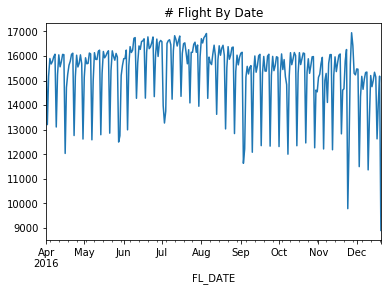

In [92]:
month_res = train.groupby(pd.Grouper(key = 'FL_DATE', freq='D'))['ARR_DEL15'].count()
month_res.plot(title='# Flight By Date')

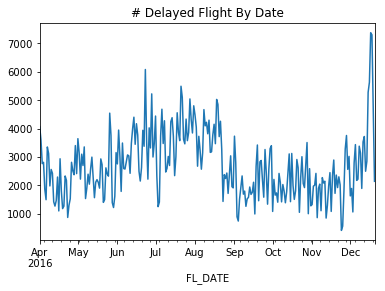

In [93]:
month_res = train.groupby(pd.Grouper(key = 'FL_DATE', freq='D'))['ARR_DEL15'].apply(lambda x: (x==1).sum())
month_res.plot(title='# Delayed Flight By Date')

In [94]:
train['ARR_DEL15'].value_counts()

0.0    3332525
1.0     714142
Name: ARR_DEL15, dtype: int64

## Feature Engineering

In [8]:
train = train.drop('FL_DATE', axis=1)
val = val.drop('FL_DATE', axis=1)
data = data.drop('FL_DATE', axis=1)

In [9]:
for col in ['UNIQUE_CARRIER','FL_NUM', 'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST','DEST_CITY_NAME']:
    le = LabelEncoder()
    le.fit(data[col].astype(str))
    train[col] = le.transform(train[col].astype(str))
    val[col] = le.transform(val[col].astype(str))

In [10]:
train.head()

,DAY_OF_WEEK,UNIQUE_CARRIER,FL_NUM,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CRS_DEP_TIME,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE,day_of_month
1547213,5.0,3,193,19,17,270,257,1050.0,0.0,327.0,2139.0,1
1478782,5.0,0,937,150,134,63,54,1355.0,1.0,95.0,427.0,1
1478783,5.0,0,938,107,98,231,229,750.0,0.0,161.0,992.0,1
1478784,5.0,0,940,77,296,294,285,1130.0,0.0,147.0,814.0,1
1478785,5.0,0,940,295,285,77,296,1437.0,0.0,129.0,814.0,1


In [11]:
def target_encoding_train(train, col, splits=5):
    kf = KFold(n_splits=splits)
    train[col+"_mean_enc"] = np.nan
    for train_index, test_index in kf.split(train):
        split_big, split_small = train.iloc[train_index,:], train.iloc[test_index,:]
        mean_col = split_big.groupby(col)['ARR_DEL15'].mean()
        train[col+"_mean_enc"].iloc[test_index] = train[col].iloc[test_index].map(mean_col)
    global_mean = train['ARR_DEL15'].mean()
    train[col+"_mean_enc"].fillna(global_mean, inplace=True)
    
def target_encoding_test(test, train, col):
    mean_col_spot = train.groupby(col)['ARR_DEL15'].mean()
    global_mean = train['ARR_DEL15'].mean()
    test[col+"_mean_enc"] = test[col].map(mean_col_spot)
    test[col+"_mean_enc"].fillna(global_mean, inplace=True)

In [12]:
to_target_encode = ['DAY_OF_WEEK', 'UNIQUE_CARRIER', 'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST', 'DEST_CITY_NAME','day_of_month']

for col in to_target_encode:
    target_encoding_train(train, col)
    target_encoding_test(val,train,col)

/Users/feiran/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
# train = train.drop(to_target_encode, axis=1)
# val = val.drop(to_target_encode, axis=1)

In [14]:
train.columns

Index(['DAY_OF_WEEK', 'UNIQUE_CARRIER', 'FL_NUM', 'ORIGIN', 'ORIGIN_CITY_NAME',
       'DEST', 'DEST_CITY_NAME', 'CRS_DEP_TIME', 'ARR_DEL15',
       'CRS_ELAPSED_TIME', 'DISTANCE', 'day_of_month', 'DAY_OF_WEEK_mean_enc',
       'UNIQUE_CARRIER_mean_enc', 'ORIGIN_mean_enc',
       'ORIGIN_CITY_NAME_mean_enc', 'DEST_mean_enc', 'DEST_CITY_NAME_mean_enc',
       'day_of_month_mean_enc'],
      dtype='object')

## Random Forest Model

In [15]:
f_names = train.drop(['ARR_DEL15'],1).columns

X_train = train.loc[:, f_names].values
y_train = train.loc[:, 'ARR_DEL15'].values.ravel()
X_val = val.loc[:, f_names].values
y_val = val.loc[:, 'ARR_DEL15'].values.ravel()

In [61]:
def report_score(model):
    y_train_fit = model.predict(X_train)
    y_val_fit = model.predict(X_val)
    
    recall = np.round(sklearn.metrics.recall_score(y_val, y_val_fit),3)
    precision = np.round(sklearn.metrics.precision_score(y_val, y_val_fit),3)
    f1 = np.round(sklearn.metrics.f1_score(y_val, y_val_fit),3)
    
    
    acc_train = np.round(sklearn.metrics.accuracy_score(y_train, y_train_fit),3)
    acc_val = np.round(sklearn.metrics.accuracy_score(y_val, y_val_fit),3)
    
    y_train_fit_proba = model.predict_proba(X_train)
    y_val_fit_proba = model.predict_proba(X_val)
    log_loss_train = np.round(sklearn.metrics.log_loss(y_train, y_train_fit_proba),3)
    log_loss_val = np.round(sklearn.metrics.log_loss(y_val, y_val_fit_proba),3)
    
    print('Precision score for val:', precision,'; Recall score for val:', recall)
    print('Accuracy for train:',  acc_train, '; Accuracy for val:', acc_val, '; F1 score for val:', f1)
    print('Log Loss for train:', log_loss_train, 'Log Loss for val:', log_loss_val)

In [31]:
# baseline RF
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)
report_score(rf)

Precision score for val: 0.322 ; Recall score for val: 0.044
Accuracy for train: 0.982 ; F score for val: 0.796
Log Loss for train: 0.105 Log Loss for val: 1.358


In [32]:
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))
set_rf_samples(50000)

In [36]:
rf = RandomForestClassifier(n_estimators = 20, max_features = 0.5, min_samples_leaf = 50, n_jobs=-1)
rf.fit(X_train, y_train)
report_score(rf)

Precision score for val: 0.333 ; Recall score for val: 0.0
Accuracy for train: 0.824 ; Accuracy for val: 0.805
Log Loss for train: 0.43 Log Loss for val: 0.482


In [39]:
rf.predict(X_val).sum()

6.0

## Upsampling

In [48]:
up_train = train.loc[train['ARR_DEL15']==1,:]
train_upsampled = train.append(up_train).append(up_train)

In [50]:
train.shape

(4046667, 19)

In [53]:
train_upsampled.shape

(5474951, 19)

In [54]:
f_names = train.drop(['ARR_DEL15'],1).columns

X_train = train_upsampled.loc[:, f_names].values
y_train = train_upsampled.loc[:, 'ARR_DEL15'].values
X_val = val.loc[:, f_names].values
y_val = val.loc[:, 'ARR_DEL15'].values

In [55]:
rf = RandomForestClassifier(n_estimators = 20, max_features = 0.5, min_samples_leaf = 50, n_jobs=-1)
rf.fit(X_train, y_train)
report_score(rf)

Precision score for val: 0.284 ; Recall score for val: 0.285
Accuracy for train: 0.671 ; Accuracy for val: 0.721
Log Loss for train: 0.609 Log Loss for val: 0.56


In [57]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_})

In [62]:
for tn in [20,50,100]:
    for ms in [3,10,50]:
        print('number of trees:', tn, '; min samples per leaf:', ms)
        rf = RandomForestClassifier(n_estimators = tn, max_features = 0.5, min_samples_leaf = ms, n_jobs=-1)
        rf.fit(X_train, y_train)
        report_score(rf)

number of trees: 20 ; min samples per leaf: 3
Precision score for val: 0.277 ; Recall score for val: 0.302
Accuracy for train: 0.684 ; Accuracy for val: 0.711 ; F1 score for val: 0.289
Log Loss for train: 0.596 Log Loss for val: 0.569
number of trees: 20 ; min samples per leaf: 10
Precision score for val: 0.294 ; Recall score for val: 0.285
Accuracy for train: 0.681 ; Accuracy for val: 0.728 ; F1 score for val: 0.29
Log Loss for train: 0.599 Log Loss for val: 0.558
number of trees: 20 ; min samples per leaf: 50
Precision score for val: 0.296 ; Recall score for val: 0.28
Accuracy for train: 0.671 ; Accuracy for val: 0.73 ; F1 score for val: 0.288
Log Loss for train: 0.61 Log Loss for val: 0.555
number of trees: 50 ; min samples per leaf: 3
Precision score for val: 0.299 ; Recall score for val: 0.286
Accuracy for train: 0.696 ; Accuracy for val: 0.73 ; F1 score for val: 0.292
Log Loss for train: 0.585 Log Loss for val: 0.557
number of trees: 50 ; min samples per leaf: 10
Precision score 

In [63]:
rf = RandomForestClassifier(n_estimators = 20, max_features = 0.5, min_samples_leaf = 10, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [69]:
fi = rf_feat_importance(rf, train.loc[:, f_names])
fi = fi.sort_values('imp',ascending =False)[:10]

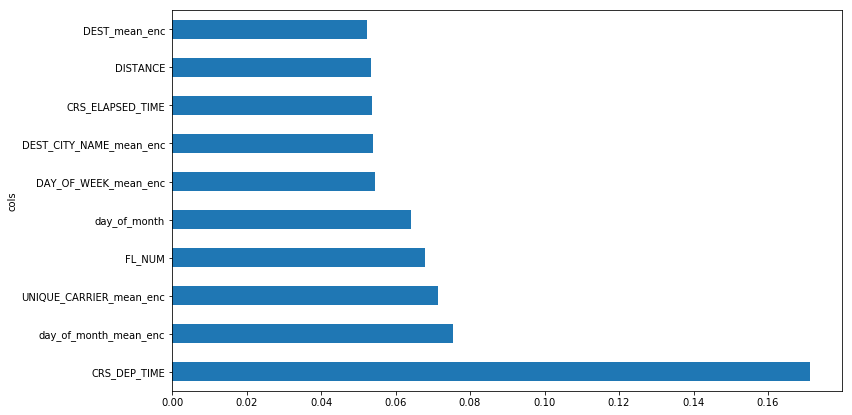

In [70]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi)

## Gradient Boosting Model

In [40]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
val_scaled = pd.DataFrame(scaler.transform(val), columns=val.columns)

In [41]:
f_names = train.drop(['ARR_DEL15'],1).columns

X_train = train.loc[:, f_names].values
y_train = train.loc[:, 'ARR_DEL15'].values
X_val = val.loc[:, f_names].values
y_val = val.loc[:, 'ARR_DEL15'].values

In [44]:
xgb_model = xgb.XGBClassifier(max_depth=200, n_estimators=200, learning_rate=0.000005)
xgb_model.fit(X_train,y_train)
report_score(xgb_model)

KeyboardInterrupt: 